# CNTK 103 Part A: MNIST Data Loader

This tutorial is targeted to individuals who are new to CNTK and to machine learning. We assume you have completed or are familiar with CNTK 101 and 102. In this tutorial, we will download and pre-process the MNIST digit images to be used for building different models to recognize handwritten digits. We will extend CNTK 101 and 102 to be applied to this data set. Additionally we will introduce a convolutional network to achieve superior performance. This is the first example, where we will train and evaluate a neural network based model on read real world data.  

CNTK 103 tutorial is divided into multiple parts:
- Part A: Familiarize with the [MNIST][] database that will be used later in the tutorial
- Subsequent parts in this 103 series would be using the MNIST data with different types of networks.


[MNIST]: http://yann.lecun.com/exdb/mnist/



In [1]:
# Import the relevant modules to be used later
from __future__ import print_function
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import struct
import sys

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Config matplotlib for inline plotting
%matplotlib inline

## Data download

We will download the data into local machine. The MNIST database is a standard handwritten digits that has been widely used for training and testing of machine learning algorithms. It has a training set of 60,000 images and a test set of 10,000 images with each image being 28 x 28 pixels. This set is easy to use visualize and train on any computer.

In [2]:
# Functions to load MNIST images and unpack into train and test set.
# - loadData reads image data and formats into a 28x28 long array
# - loadLabels reads the corresponding labels data, 1 for each image
# - load packs the downloaded image and labels data into a combined format to be read later by 
#   CNTK text reader 

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))


# Download the data

The MNIST data is provided as train and test set. Training set has 60000 images while the test set has 10000 images. Let us download the data.

In [3]:
# URLs for the train image and labels data
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)


url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)

Done.
Done.
Done.
Done.


# Visualize the data

Image Label:  3


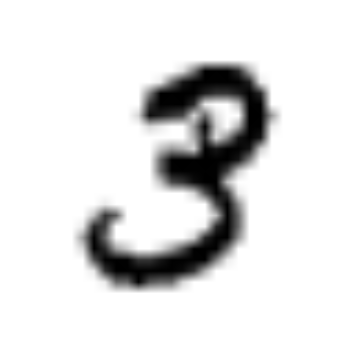

In [4]:
# Plot a random image
sample_number = 5001
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

# Save the images

Save the images in a local directory. While saving the data we flatten the images to a vector (28x28 image pixels becomes an array of length 784 data points) and the labels are encoded as [1-hot][] encoding (label of 3 with 10 digits becomes `0010000000`.

[1-hot]: https://en.wikipedia.org/wiki/One-hot

In [5]:
# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)


In [6]:
# Save the train and test files (prefer our default path for the data)
data_dir = os.path.join("..", "Examples", "Image", "DataSets", "MNIST")
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

print('Done')

Writing train text file...
Saving ..\Examples\Image\DataSets\MNIST\Train-28x28_cntk_text.txt
Writing test text file...
Saving ..\Examples\Image\DataSets\MNIST\Test-28x28_cntk_text.txt
Done


**Suggested Explorations**

One can do data manipulations to improve the performance of a machine learning system. I suggest you first use the data generated so far and run the classifier in subsequent parts of the CNTK 103 tutorial series. Once you have a baseline with classifying the data in its original form, now use the different data manipulation techniques to further improve the model.

There are several ways data alterations can be performed. CNTK readers automate a lot of these actions for you. However, to get a feel for how these transforms can impact training and test accuracies, I strongly encourage individuals to try one or more of data perturbation.

- Shuffle the training data (rows to create a different). Hint: Use `permute_indices = np.random.permutation(train.shape[0])`. Then run Part B of the tutorial with this newly permuted data.
- Adding noise to the data can often improves [generalization error][]. You can augment the training set by adding  noise (generated with numpy, hint: use `numpy.random`) to the training images. 
- Distort the images with [affine transformation][] (translations or rotations)

[generalization error]: https://en.wikipedia.org/wiki/Generalization_error
[affine transformation]: https://en.wikipedia.org/wiki/Affine_transformation
